<a href="https://colab.research.google.com/github/A-Burnhard/Major-Atmospheric-Gamma-Imaging-Cherenkov-Telescope-project-MAGIC-/blob/main/MAGIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler


**Dataset** 
 1.Title of Database: MAGIC gamma telescope data 2004

2. Sources:

   (a) Original owner of the database:

       R. K. Bock
       Major Atmospheric Gamma Imaging Cherenkov Telescope project (MAGIC)
       http://wwwmagic.mppmu.mpg.de
       rkb@mail.cern.ch


In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive//Machine Learning/magic04.data'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class" ]
df = pd.read_csv(file_path, names=cols)
df.head()


In [22]:
df["class"] = (df["class"] == "g").astype(int)

df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,1
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,1
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,1
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,1
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,1


In [ ]:
for label in cols[:-1]:
  data_gamma= df[df["class"]==1][label],
  data_hadron = df[df["class"]==0][label], 
 
  plt.hist(data_gamma, color='blue',label='gamma', alpha=0.7, density=True, histtype = 'bar')
  plt.hist(data_hadron, color='red', label='hadron',alpha=0.7, density=True, histtype = 'bar')
  plt.title(label)
  plt.ylabel("Probability")
  plt.xlabel(label)
  plt.legend()
  plt.show()

**Train, Validation, test datasets**

In [6]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])


Between 60% and 80% wil go towards validation and from 80% to 100% will be the test data.

**Scaling dataset** using Standard Deviation
Hstack = convert to 2D Numpy

In [7]:
def scale_dataset(dataframe, oversample):
  x = dataframe[dataframe.columns[:-1]].values
  y = dataframe[dataframe.columns[-1]].values

  scaler= StandardScaler()
  x = scaler.fit_transform(x)

  if oversample:
    ros = RandomOverSampler()
    x,y = ros.fit_resample(x,y)

  data = np.hstack((x,np.reshape(y,(-1,1))))

  return data, x, y

In [8]:
train, x_train, y_train = scale_dataset(train, oversample=True)
valid, x_valid, y_valid = scale_dataset(valid, oversample=False)
test, x_test, y_test = scale_dataset(test, oversample=False)




**KNN**

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [28]:
y_pred = knn_model.predict(x_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           g       0.83      0.88      0.86      2487
           h       0.75      0.66      0.70      1317

    accuracy                           0.81      3804
   macro avg       0.79      0.77      0.78      3804
weighted avg       0.80      0.81      0.80      3804



Naive Bayes 

In [30]:
from sklearn.naive_bayes import GaussianNB

In [31]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)

In [32]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           g       0.74      0.90      0.81      2487
           h       0.68      0.41      0.51      1317

    accuracy                           0.73      3804
   macro avg       0.71      0.65      0.66      3804
weighted avg       0.72      0.73      0.71      3804



In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train, y_train)

In [35]:
y_pred = lg_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           g       0.85      0.82      0.83      2487
           h       0.68      0.72      0.70      1317

    accuracy                           0.79      3804
   macro avg       0.76      0.77      0.77      3804
weighted avg       0.79      0.79      0.79      3804



**Support Vector Machine (SVM)**

In [36]:
from sklearn.svm import SVC

In [37]:
svm_model = SVC()
svm_model = svm_model.fit(x_train,y_train)

In [38]:
y_pred = svm_model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           g       0.89      0.90      0.89      2487
           h       0.80      0.79      0.80      1317

    accuracy                           0.86      3804
   macro avg       0.85      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



**Neural Networks (NN)**

In [98]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
import tensorflow as tf

In [99]:
from sklearn.preprocessing import LabelEncoder

# Encode labels 'g' and 'h' as 0 and 1 respectively
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)


In [100]:
y_train = np.array(y_train).astype('float32')


In [101]:
def plot_history(history):
  fig,(ax1,ax2) = plt.subplots(1,2, figsize= (10,4))
  ax1.plot(history.history['loss'], label='loss')
  ax1.plot(history.history['val_loss'], label='val_loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Binary Crossentropy')
  ax1.grid(True)

  ax2.plot(history.history['accuracy'], label='accuracy')
  ax2.plot(history.history['val_accuracy'], label='val_accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.grid(True)

  plt.show()

In [ ]:
plot_history(history)

In [102]:
def train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs):
  nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid'),
        ])

  nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
  
  history =  nn_model.fit(
      x_train, y_train, epochs=epochs, batch_size = batch_size, validation_split=0.2, verbose=0
  )
  return nn_model, history
 

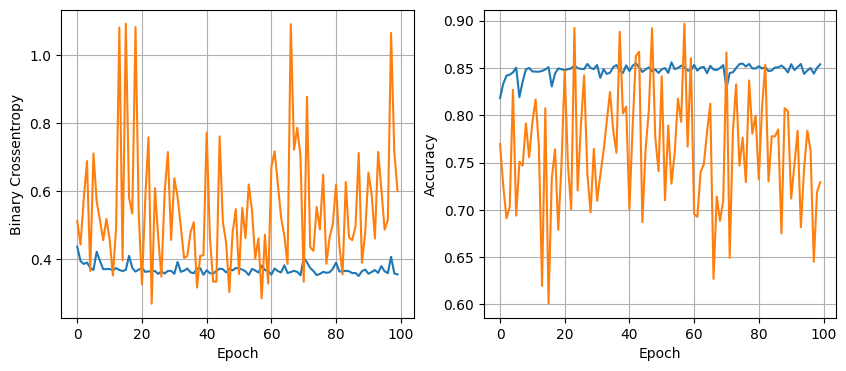

UnimplementedError: ignored

In [103]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
for num_nodes in [16,32,64]:
  for dropout_prob in [0, 0.2]:
    for lr in [0.1,0.005, 0.001]:
      for batch_size in [32, 64, 120]: 
        model , history = train_model(x_train, y_train,num_nodes, dropout_prob, lr, batch_size, epochs)
        plot_history(history)
        val_loss = model.evaluate(x_valid, y_valid)[0]
        if val_loss < least_val_loss:
          least_val_loss = val_loss
          least_loss_model = model


In [96]:
y_pred = least_loss_model.predict(x_test)
y_pred = (y_pred >0.5)
y_pred


AttributeError: ignored